In [159]:
import random

import pandas as pd
!pip install torchvision
!pip install pydub

Python(64819) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(64901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [163]:
import torch
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
from pydub import AudioSegment
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from torch.utils.data import Dataset, DataLoader
import os
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.optim as optim
import importlib

In [1]:
# Local imports
import data_utils
from utils import load_protocol, plot_results
import train_utils
import audio_utils
from models.resnet_modified import ResNetBinaryClassifier

/Users/roeeseren/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [165]:
dataset_path = data_utils.get_data()

In [166]:
train_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_train/flac"
val_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_dev/flac"
test_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_eval/flac"

In [167]:
# Load the .flac file
example_file = f"{dataset_path}/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1004407.flac"
audio = AudioSegment.from_file(example_file, format="flac")

audio

Python(65110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65113) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [168]:
def audio_to_mel_spectrogram(audio_path, n_fft=400, hop_length=160, n_mels=64):
    """
    Convert an audio file to a mel-spectrogram using librosa.
    """
    
    # Load audio file
    waveform, sample_rate = librosa.load(audio_path, sr=None)

    # Generate mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize to [0, 1]
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.min()) / (log_mel_spectrogram.max() - log_mel_spectrogram.min())

    return log_mel_spectrogram

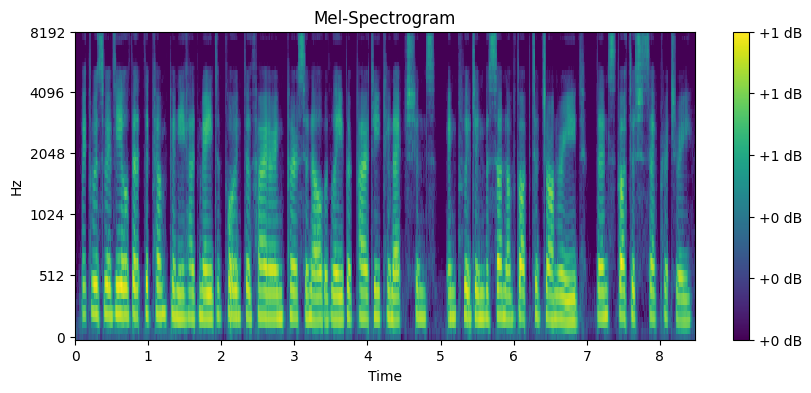

In [169]:
# Example usage
mel_spectrogram = audio_to_mel_spectrogram(example_file)

# Visualize the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=16000, hop_length=160, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.show()

In [195]:
col_names = ['speaker', 'file_name', 'attack', 'label']
protocols_folder = "LA/LA/ASVspoof2019_LA_cm_protocols"
protocol_file_prefix = "ASVspoof2019.LA.cm"
data_info_train_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.train.trn.txt"
data_info_val_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.dev.trl.txt"
data_info_test_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.eval.trl.txt"

train_df_info = load_protocol(data_info_train_file_path, names=col_names)
val_df_info = load_protocol(data_info_val_file_path, names=col_names)
test_df_info = load_protocol(data_info_test_file_path, names=col_names)

In [196]:
print("Train dataset info:")
print(train_df_info.head())
print('-' * 40)
print("Val dataset info:")
print(val_df_info.head())
print('-' * 40)
print("Test dataset info:")
print(test_df_info.head())

Train dataset info:
   speaker     file_name attack     label
0  LA_0079  LA_T_1138215      -  bonafide
1  LA_0079  LA_T_1271820      -  bonafide
2  LA_0079  LA_T_1272637      -  bonafide
3  LA_0079  LA_T_1276960      -  bonafide
4  LA_0079  LA_T_1341447      -  bonafide
----------------------------------------
Val dataset info:
   speaker     file_name attack     label
0  LA_0069  LA_D_1047731      -  bonafide
1  LA_0069  LA_D_1105538      -  bonafide
2  LA_0069  LA_D_1125976      -  bonafide
3  LA_0069  LA_D_1293230      -  bonafide
4  LA_0069  LA_D_1340209      -  bonafide
----------------------------------------
Test dataset info:
   speaker     file_name attack  label
0  LA_0039  LA_E_2834763    A11  spoof
1  LA_0014  LA_E_8877452    A14  spoof
2  LA_0040  LA_E_6828287    A16  spoof
3  LA_0022  LA_E_6977360    A09  spoof
4  LA_0031  LA_E_5932896    A13  spoof


In [197]:
train_df_info[['label']].value_counts()

label   
spoof       22800
bonafide     2580
Name: count, dtype: int64

Since there are much more spoof files than real files, we're going to
remove some of the spoof data - to balance our data

In [198]:
bonafide_rows = train_df_info[train_df_info['label'] == 'bonafide']
spoof_rows = train_df_info[train_df_info['label'] == 'spoof'].sample(n=len(bonafide_rows))

train_df_info = pd.concat([bonafide_rows, spoof_rows], ignore_index=True)

In [199]:
train_df_info[['label']].value_counts()

label   
bonafide    2580
spoof       2580
Name: count, dtype: int64

In [200]:
# Add augmentations to train data
train_df_info = audio_utils.add_augmentations(train_dir, train_df_info)

In [201]:
# After augmentations
train_df_info[['label']].value_counts()

label   
spoof       3232
bonafide    3218
Name: count, dtype: int64

In [218]:
val_df_info['label'].value_counts()

label
spoof       22296
bonafide     2548
Name: count, dtype: int64

In [202]:
train_df = data_utils.process_data_frame(train_dir, train_df_info)
val_df = data_utils.process_data_frame(val_dir, val_df_info)
test_df = data_utils.process_data_frame(test_dir, test_df_info)

      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0
      file_name label
0  LA_D_1047731     0
1  LA_D_1105538     0
2  LA_D_1125976     0
3  LA_D_1293230     0
4  LA_D_1340209     0
      file_name label
0  LA_E_2834763     1
1  LA_E_8877452     1
2  LA_E_6828287     1
3  LA_E_6977360     1
4  LA_E_5932896     1


In [204]:
def resize_spectrogram(spectrogram, fixed_time_steps=192):
    """
    Resize the spectrogram to a fixed time dimension using interpolation.
    """
    n_mels, time_steps = spectrogram.shape

    # Calculate the zoom factor for the time dimension
    zoom_factor = (1, fixed_time_steps / time_steps)

    # Resize the spectrogram using interpolation
    resized_spectrogram = zoom(spectrogram, zoom_factor)

    return resized_spectrogram

In [205]:
class ASVSpoofDataset(Dataset):
    def __init__(self, audio_dir, data_info_df, fixed_time_steps=192):
        """
        Args:
            audio_dir (str): Directory with all the audio files.
        """
        self.audio_dir = audio_dir
        self.audio_files = os.listdir(audio_dir)
        self.data_info_df = data_info_df
        self.fixed_time_steps = fixed_time_steps

    def __len__(self):
        return min(len(self.data_info_df), len(self.audio_files))

    def __getitem__(self, idx):
        current_audio_path = os.path.join(self.audio_dir, f"{self.data_info_df.iloc[idx]['file_name']}.flac")
        spectrogram = audio_to_mel_spectrogram(current_audio_path)
        
        # Resize the spectrogram
        mel_spectrogram = resize_spectrogram(spectrogram, self.fixed_time_steps)

        # Convert to tensor and add channel dimension
        mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)

        # Get label (0 for real, 1 for spoofed)
        label = self.data_info_df.iloc[idx]['label']

        return mel_spectrogram, float(label)

In [206]:
train_dataset = ASVSpoofDataset(train_dir, train_df)
val_dataset = ASVSpoofDataset(val_dir, val_df)
test_dataset = ASVSpoofDataset(test_dir, test_df)

In [207]:
print(f"Example of train dataset value - shape: {train_dataset[0][0].shape}, label: {train_dataset[0][1]}")
print('-' * 75)
print(f"Example of val dataset value - shape: {val_dataset[0][0].shape}, label: {val_dataset[0][1]}")

Example of train dataset value - shape: torch.Size([1, 64, 192]), label: 0.0
---------------------------------------------------------------------------
Example of val dataset value - shape: torch.Size([1, 64, 192]), label: 0.0


In [208]:
def initialize_model():# Load ResNet18 with pretrained weights
    resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    # Modify the first layer to accept 1-channel input
    resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Modify the final layer for binary classification
    resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)
    
    # Add a sigmoid activation for binary output
    resnet18 = nn.Sequential(resnet18, nn.Sigmoid())
    
    return resnet18


In [209]:
train_df.tail()

,file_name,label
6445,aug_LA_T_1625761,0
6446,aug_LA_T_8610538,1
6447,aug_LA_T_5029038,0
6448,aug_LA_T_6499936,0
6449,aug_LA_T_7318840,1


In [212]:
# Hyperparameters
importlib.reload(train_utils)
LEARNING_RATE = 0.001
BATCH_SIZE = 256
resnet18 = ResNetBinaryClassifier()
EPOCHS = 6
optimizer = torch.optim.RMSprop(resnet18.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Move model to GPU ifQ available
device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = resnet18.to(device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

last_val_accuracy, best_val, history = train_utils.train_model(resnet18, train_loader, val_loader, criterion, optimizer, EPOCHS, device)

Progress of epoch 1/6: loop 0/26 finished
Epoch [1/6], Loss: 0.5989, Train Accuracy: 77.21%, Val Accuracy: 0.14%
Progress of epoch 2/6: loop 0/26 finished
Epoch [2/6], Loss: 0.5540, Train Accuracy: 87.10%, Val Accuracy: 0.82%
Progress of epoch 3/6: loop 0/26 finished
Epoch [3/6], Loss: 0.5487, Train Accuracy: 88.37%, Val Accuracy: 0.25%
Progress of epoch 4/6: loop 0/26 finished
Epoch [4/6], Loss: 0.5574, Train Accuracy: 87.12%, Val Accuracy: 0.80%
Progress of epoch 5/6: loop 0/26 finished
Epoch [5/6], Loss: 0.5483, Train Accuracy: 88.33%, Val Accuracy: 0.85%
Progress of epoch 6/6: loop 0/26 finished
Epoch [6/6], Loss: 0.5461, Train Accuracy: 89.15%, Val Accuracy: 0.84%


In [154]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_data = train_utils.evaluate_model(resnet18, test_loader, criterion, device)

In [64]:
print(f"Test Accuracy: {test_data}")

Test Accuracy: {'loss': 0.41675417403451415, 'accuracy': 0.8967530917921867, 'precision': 0.8967530917921867, 'recall': 1.0, 'f1': 0.9455665006401764, 'eer': 0.5}


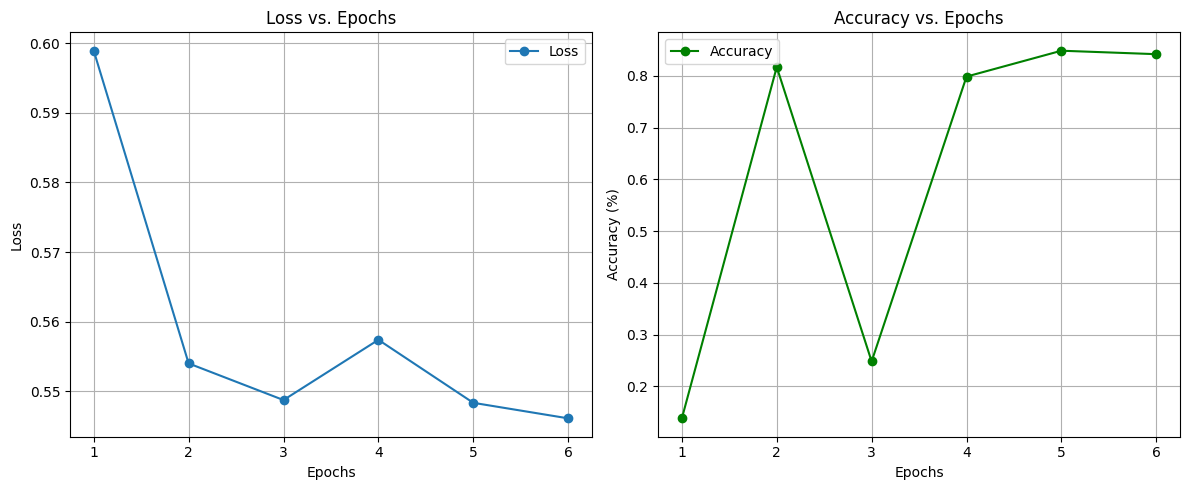

In [213]:
plot_results(history['train_loss'], history['val_accuracy'], 6)

In [219]:
torch.save(resnet18.state_dict(), "trained_models/resnet_model_weights.pth")